In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import glob
import imageio

# for interactive plots in notebook
%matplotlib inline

import scipy.integrate as integrate
import scipy.io as sio
#from Lorenz96_RK4 import Lorenz96
from L96_Model import L96
import sys, os, time, datetime
import pickle

codename = 'v04'
np.set_printoptions(precision=4, linewidth=100)

In [2]:
base_results_path = "./results/Baseline"
N500_results_path = "./results/Niter500"
N1500_results_path = "./results/Niter1500"
N50_results_path = "./results/Niter50"
N150_results_path = "./results/Niter150"
N250_results_path = "./results/Niter250"


def load_lists(path):
    mat_files = glob.glob(path + "/*.mat")
    # Load in dictionaries and relevant data
    data_dicts = []
    action_arrays = []
    action_min = []
    q_min = []
    for filename in mat_files:
        data_dicts.append(sio.loadmat(filename))
        action_arrays.append(data_dicts[-1]['Action'])
        action_min.append(data_dicts[-1]['Action_min'])
        q_min.append(data_dicts[-1]['q_min'][0][0])
    return action_arrays, action_min, q_min

base_action_arrays, base_action_min, base_q_min = load_lists(base_results_path)
N500_action_arrays, N500_action_min, N500_q_min = load_lists(N500_results_path)
N1500_action_arrays, N1500_action_min, N1500_q_min = load_lists(N1500_results_path)
N50_action_arrays, N50_action_min, N50_q_min = load_lists(N50_results_path)
N150_action_arrays, N150_action_min, N150_q_min = load_lists(N150_results_path)
N250_action_arrays, N250_action_min, N250_q_min = load_lists(N250_results_path)

(1500.0, 2500.0)

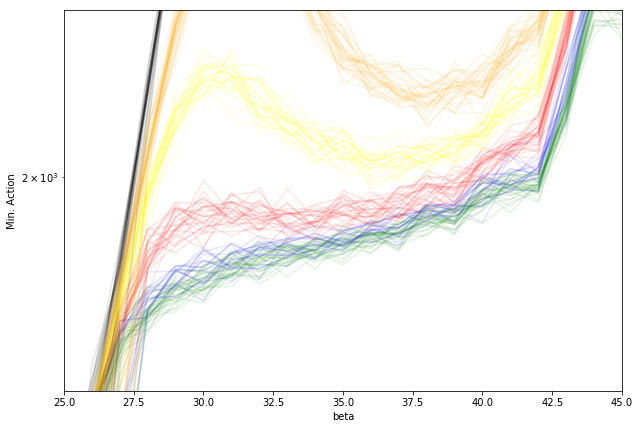

In [3]:
def plot_min_action_v_beta(action_min, color):
    for action_v_beta in action_min:
        plt.plot(np.arange(50), action_v_beta[:,0], color=color, alpha=0.1)

#     plt.title('Min. Action v. Beta, %d Initial Conditions' % len(action_min))
    plt.ylabel('Min. Action')
    plt.xlabel('beta')
    plt.yscale('log')
#     plt.savefig('ClusterResults-L=2.png')
    
#     level_off = np.mean(action_min[0][30:45,0])
#     plt.axhline(y=level_off, ls='dashed')
#     plt.text(-5,level_off,'%d'%int(level_off))
        
        
plt.figure(figsize=(10,7))
plot_min_action_v_beta(base_action_min, 'b')
plot_min_action_v_beta(N500_action_min, 'r')
plot_min_action_v_beta(N1500_action_min, 'g')
plot_min_action_v_beta(N50_action_min, 'black')
plot_min_action_v_beta(N150_action_min, 'orange')
plot_min_action_v_beta(N250_action_min, 'yellow')

plt.xlim(25,45)
plt.ylim(1.5e3,2.5e3)

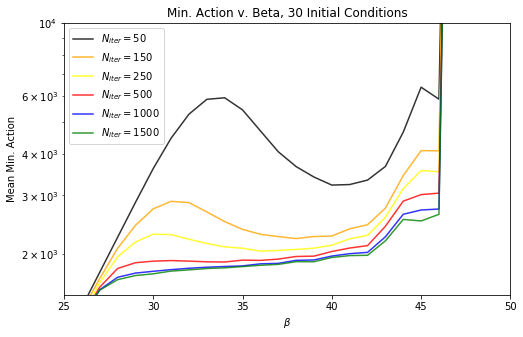

In [4]:
def plot_mean_min_action_v_beta(action_min, color, label):
#     for action_v_beta in action_min:
#         plt.plot(np.arange(50), action_v_beta[:,0], color=color, alpha=0.1)
    # Need to find the mean
    run_sum = np.zeros(shape=action_min[0].shape)
    for action_v_beta in action_min:
        run_sum += action_v_beta
    run_sum /= len(action_min)

    plt.plot(np.arange(action_min[0].shape[0]), run_sum, color=color, alpha=0.8, label=r'%s'%label)
    plt.title('Min. Action v. Beta, %d Initial Conditions' % len(action_min))
    plt.ylabel('Mean Min. Action')
    plt.xlabel(r'$\beta$')
    plt.yscale('log')
    
#     level_off = np.mean(action_min[0][30:45,0])
#     plt.axhline(y=level_off, ls='dashed')
#     plt.text(-5,level_off,'%d'%int(level_off))
        
        
plt.figure(figsize=(8,5))
plot_mean_min_action_v_beta(N50_action_min, 'black', "$N_{iter}=50$")
plot_mean_min_action_v_beta(N150_action_min, 'orange', "$N_{iter}=150$")
plot_mean_min_action_v_beta(N250_action_min, 'yellow', "$N_{iter}=250$")
plot_mean_min_action_v_beta(N500_action_min, 'r', "$N_{iter}=500$")
plot_mean_min_action_v_beta(base_action_min, 'blue', "$N_{iter}=1000$")
plot_mean_min_action_v_beta(N1500_action_min, 'g', "$N_{iter}=1500$")
plt.legend()
plt.savefig("NiterActionLevels.png")
plt.xlim(25,50)
plt.ylim(1.5e3,1e4)
plt.savefig("NiterActionLevels-Zoomed.png")

Predictions

In [5]:
# Load the data set
D = 20
dim_obs = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 17, 18]
M = 200
gen_nu = "8.17"
gen_noise = "sig0.4"
gen_dt = "0.001"
gen_delta_t = "0.025"
gen_integrator = "RK4"

# Specify the data path
datapath = ("./L96_D%s_nu%s_%s_dt%s_deltat%s_%s.mat" % 
    (str(D), gen_nu, gen_noise, gen_dt, gen_delta_t, gen_integrator))

if datapath[-3:] == "mat":
    datadict = sio.loadmat(datapath)
    data = datadict["Data"]
    dt = datadict["delta_t"][0]
elif datapath[-3:] == "npy":
    data = np.load(datapath)
else:
    raise IOError ("Does not recognize data file extension\n datapath = %s" % datapath)
    sys.exit()
# Prepare the data

Y = data[dim_obs,:M]

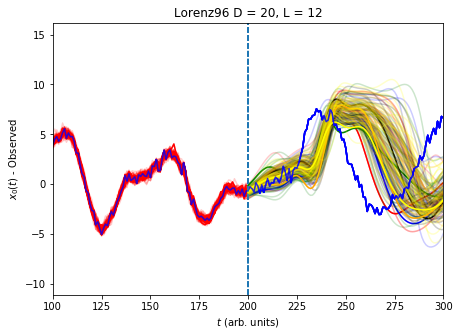

In [6]:
var = 0
beta = 30

def plot_estimate(q_min, color):
    steps = 800
    stepsize = 0.02
    t = 0


    for j in xrange(len(q_min)):
        X_min = q_min[j][0][:,:,beta]
        nu_min = q_min[j][1][:,beta]
        y = np.zeros(shape=(D,steps))
        y[:,0] = X_min[:,-1]

        for i in range(1,steps):
            k1 = stepsize * L96(y[:,i-1], nu_min)
            k2 = stepsize * L96(y[:,i-1] + k1 / 2, nu_min)
            k3 = stepsize * L96(y[:,i-1] + k2 / 2, nu_min)
            k4 = stepsize * L96(y[:,i-1] + k3, nu_min)



            # Update path
            y[:,i] = y[:,i-1] + (k1 + 2*k2 + 2*k3 + k4)/6
            t = t + stepsize


        plt.plot(np.arange(200), X_min[var,:], color='r', alpha = 1./5)
        plt.plot(np.arange(200,1000), y[var,:], color=color, alpha = 1./5)

    plt.plot(np.arange(200), X_min[var,:], color='r', alpha = 1, label='Estimate')
    plt.plot(np.arange(200,1000), y[var,:], color=color, alpha = 1, label='Prediction')
    
    plt.plot(np.arange(1000), data[var,:1000], color='b', alpha=0.8, label='Data')
    plt.xlim((100,300))
#     plt.legend()
    plt.title('Lorenz96 D = 20, L = 12')
    plt.xlabel(r'$t$ (arb. units)')
    plt.ylabel(r'$x_{%d}(t)$ - Observed'%var)
    plt.axvline(x=200,ls='dashed')
#     plt.savefig('clusterResults-obsvar.png')

plt.figure(figsize=(7,5))

plot_estimate(base_q_min, color='r')
plot_estimate(N500_q_min, color='b')
plot_estimate(N1500_q_min, color='g')
plot_estimate(N50_q_min, color='black')
plot_estimate(N150_q_min, color='orange')
plot_estimate(N250_q_min, color='yellow')

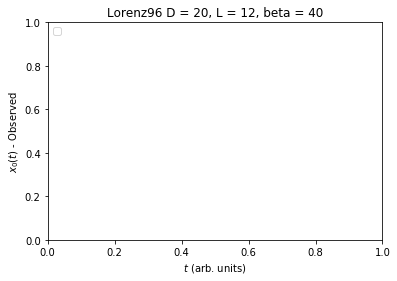

In [10]:
var = 0
beta = 40
def plot_mean_estimate(q_min, color, label, ax, var, beta):
    steps = 800
    stepsize = 0.025
    t = 0

    run_sum = np.zeros(shape=(D,steps))
    for j in xrange(len(q_min)):
        X_min = q_min[j][0][:,:,beta]
        nu_min = q_min[j][1][:,beta]
        y = np.zeros(shape=(D,steps))
        y[:,0] = X_min[:,-1]

        for i in range(1,steps):
            k1 = stepsize * L96(y[:,i-1], nu_min)
            k2 = stepsize * L96(y[:,i-1] + k1 / 2, nu_min)
            k3 = stepsize * L96(y[:,i-1] + k2 / 2, nu_min)
            k4 = stepsize * L96(y[:,i-1] + k3, nu_min)



            # Update path
            y[:,i] = y[:,i-1] + (k1 + 2*k2 + 2*k3 + k4)/6
            t = t + stepsize
        run_sum += y
        
    run_sum /= len(q_min)

#     plt.plot(np.arange(200), X_min[var,:], color=color, alpha = 0.5)
#     plt.plot(np.arange(200,1000), run_sum[var,:], color=color, alpha = 0.5, label=r'%s'%label)
    ax.plot(np.arange(200), X_min[var,:], color=color, alpha = 0.5)
    ax.plot(np.arange(200,1000), run_sum[var,:], color=color, alpha = 0.5, label=r'%s'%label)
    
    
#     plt.plot(np.arange(1000), data[var,:1000], color='b', alpha=0.8, label='Data')
    ax.set_xlim((100,300))

    ax.axvline(x=200,ls='dashed')
#     plt.savefig('clusterResults-obsvar.png')

# plt.figure(figsize=(8,5))
# plt.plot(np.arange(1000), data[var,:1000], color='b', alpha=0.8, label='Data')

# plot_mean_estimate(N50_q_min, color='black', label='$N_{iter}=50$')
# plot_mean_estimate(N150_q_min, color='orange', label='$N_{iter}=150$')
# plot_mean_estimate(N250_q_min, color='yellow', label='$N_{iter}=250$')
# plot_mean_estimate(N500_q_min, color='green', label='$N_{iter}=500$')
# plot_mean_estimate(base_q_min, color='r', label='$N_{iter}=1000$')
# plot_mean_estimate(N1500_q_min, color='orange', label='$N_{iter}=1500$')



plt.title('Lorenz96 D = 20, L = 12, beta = %d' % beta)
plt.xlabel(r'$t$ (arb. units)')
plt.ylabel(r'$x_{%d}(t)$ - Observed'%var)
plt.legend(loc=2)
plt.savefig("NiterEstimations-Obs.png")
plt.show()

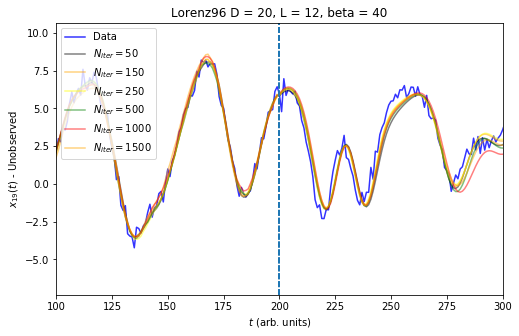

In [8]:
var = 19


plt.figure(figsize=(8,5))
plt.plot(np.arange(1000), data[var,:1000], color='b', alpha=0.8, label='Data')

plot_mean_estimate(N50_q_min, color='black', label='$N_{iter}=50$')
plot_mean_estimate(N150_q_min, color='orange', label='$N_{iter}=150$')
plot_mean_estimate(N250_q_min, color='yellow', label='$N_{iter}=250$')
plot_mean_estimate(N500_q_min, color='green', label='$N_{iter}=500$')
plot_mean_estimate(base_q_min, color='r', label='$N_{iter}=1000$')
plot_mean_estimate(N1500_q_min, color='orange', label='$N_{iter}=1500$')

plt.title('Lorenz96 D = 20, L = 12, beta = %d' % beta)
plt.xlabel(r'$t$ (arb. units)')
plt.ylabel(r'$x_{%d}(t)$ - Unobserved'%var)
plt.legend(loc=2)
plt.savefig("NiterEstimations-Unobs.png")
plt.show()

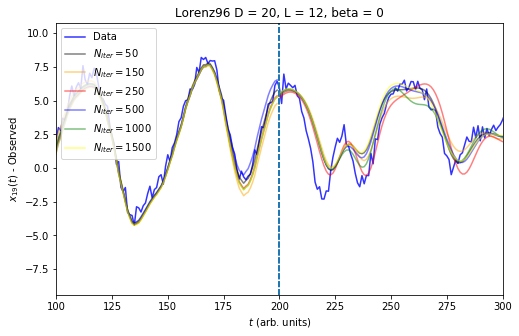

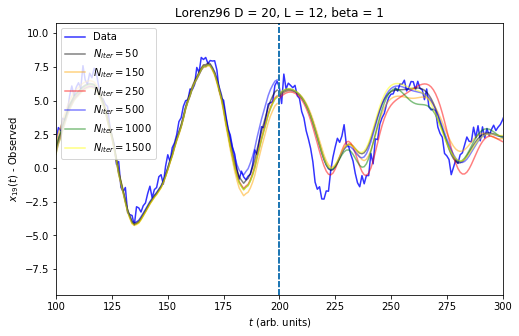

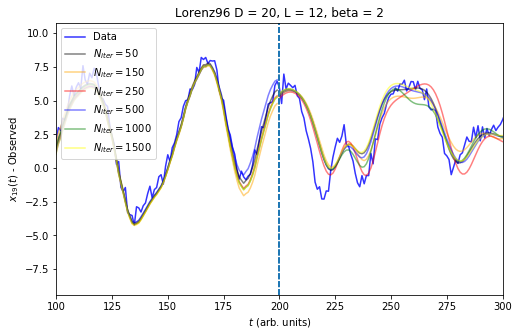

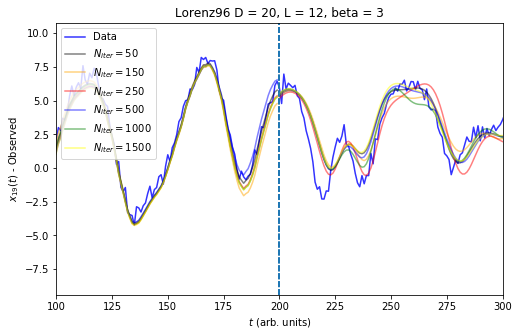

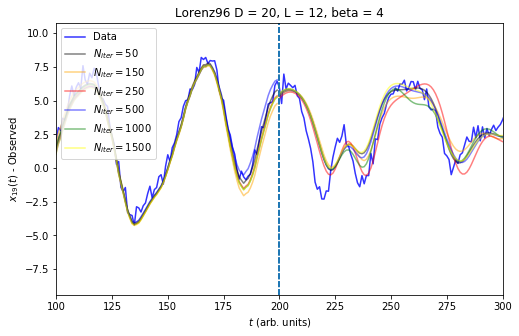

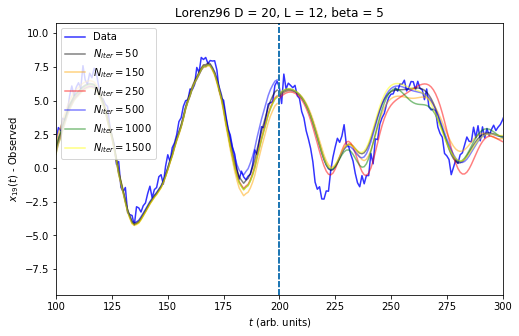

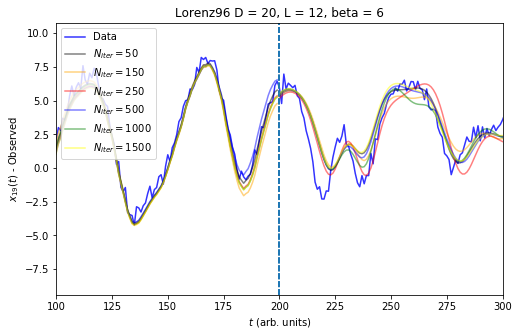

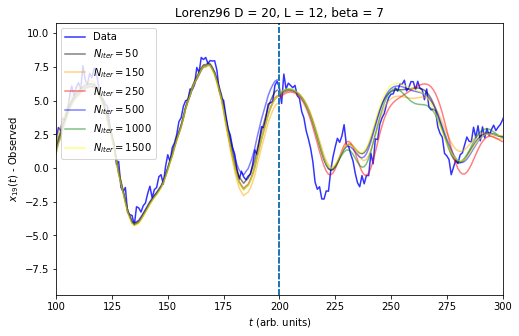

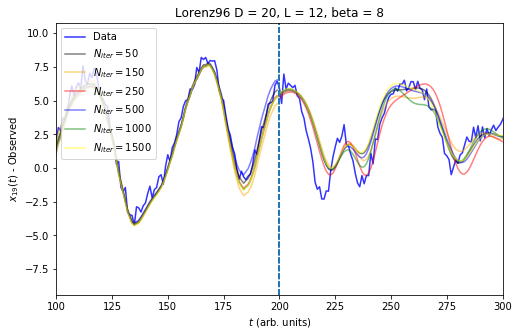

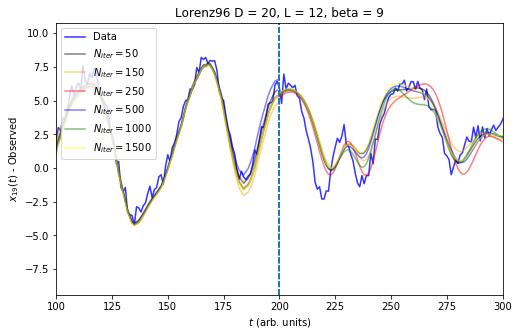

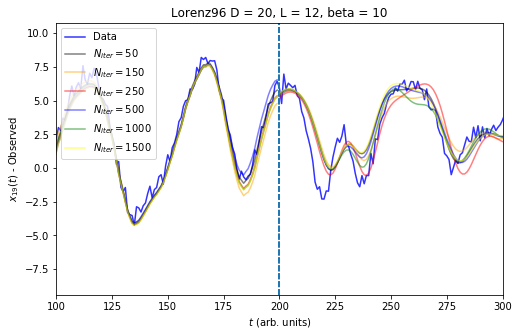

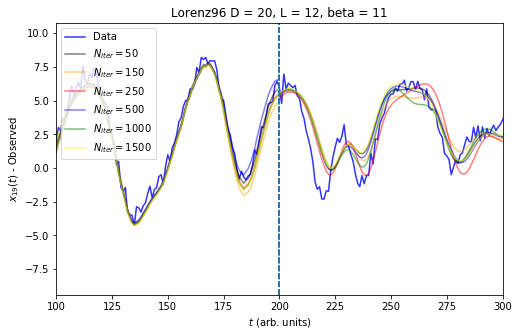

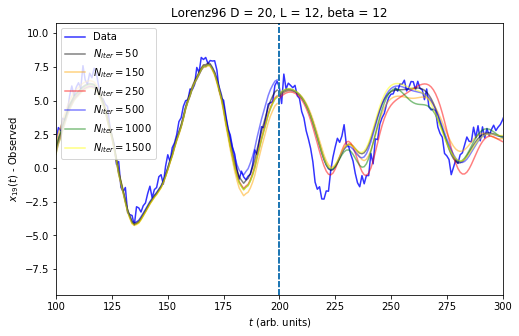

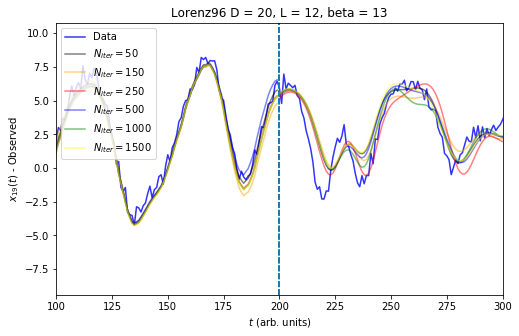

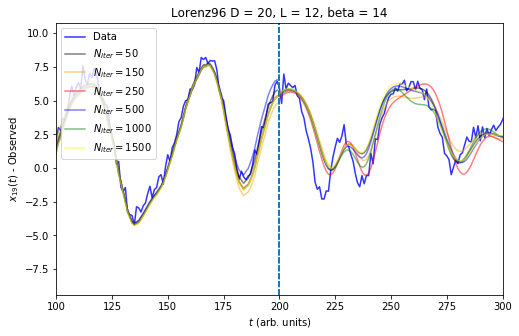

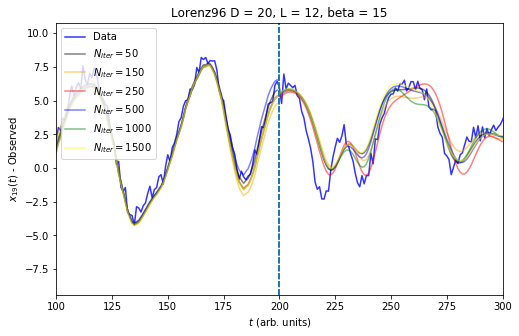

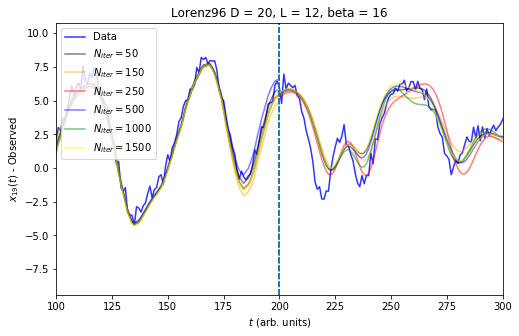

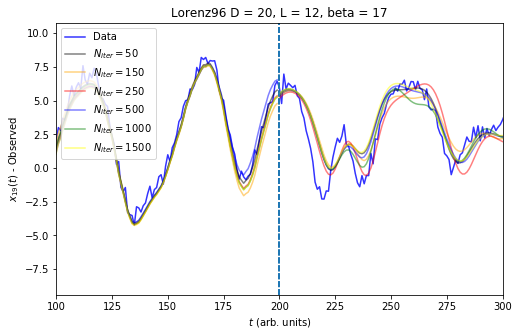

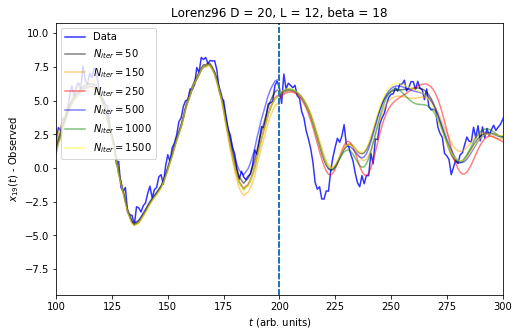

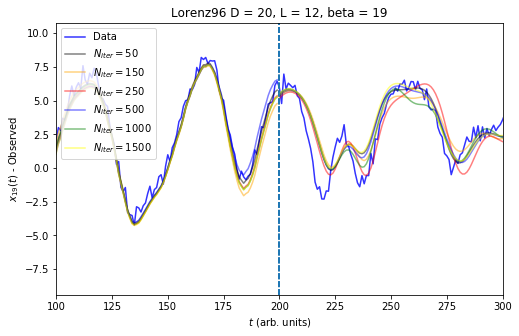

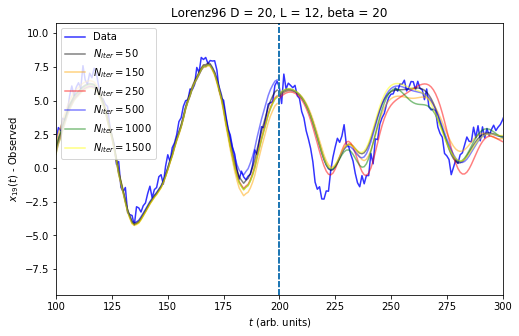

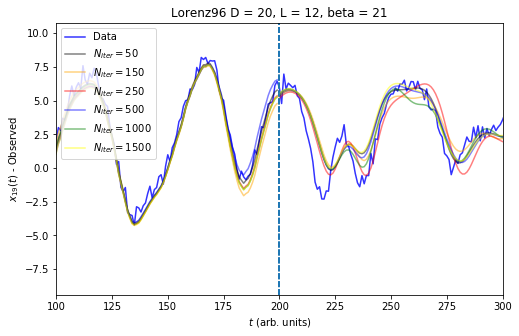

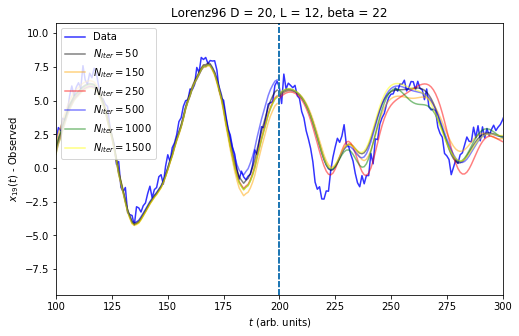

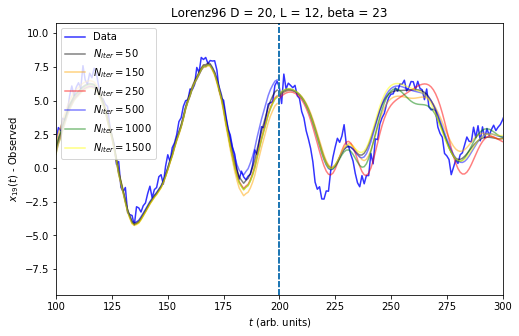

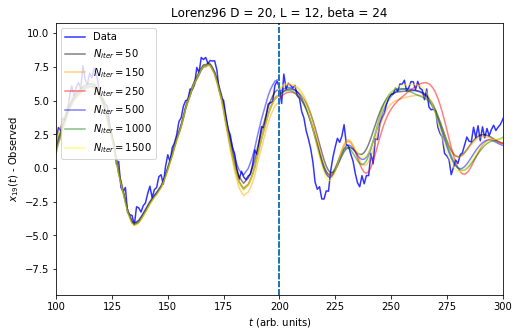

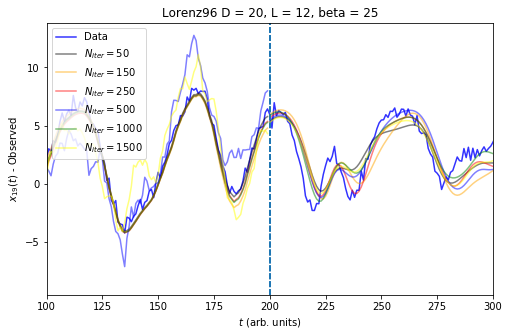

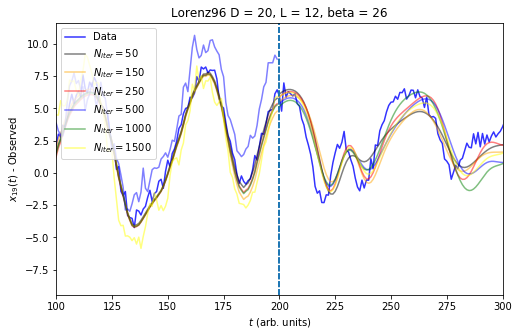

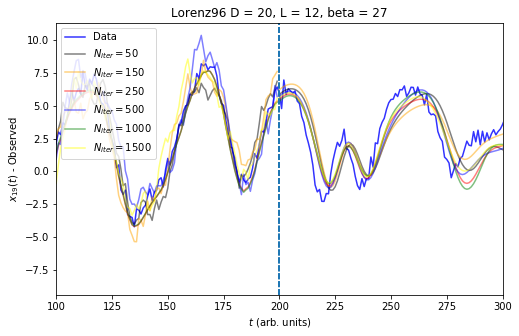

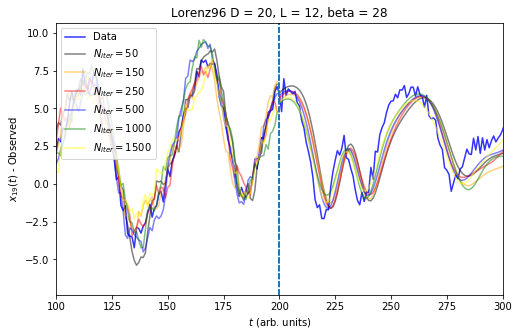

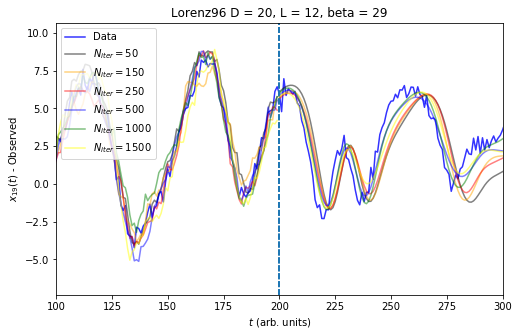

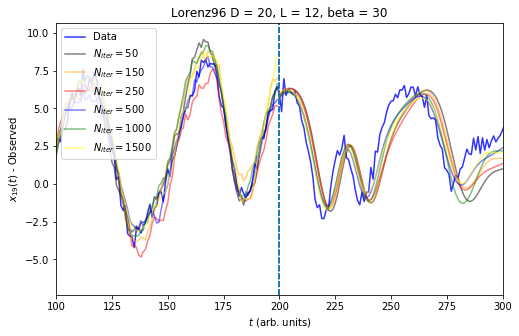

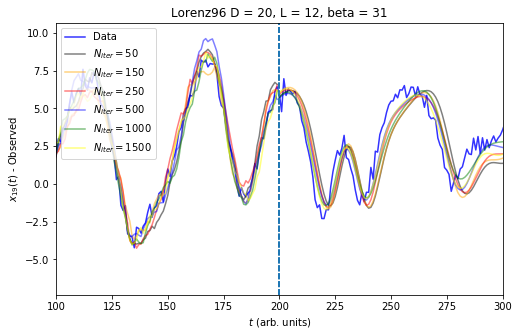

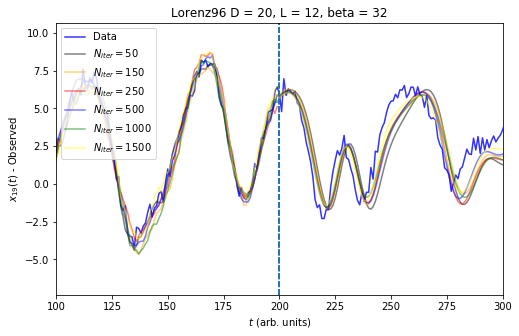

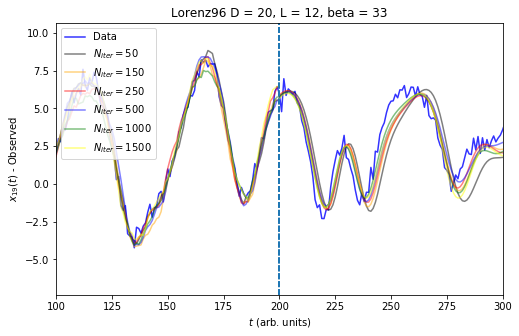

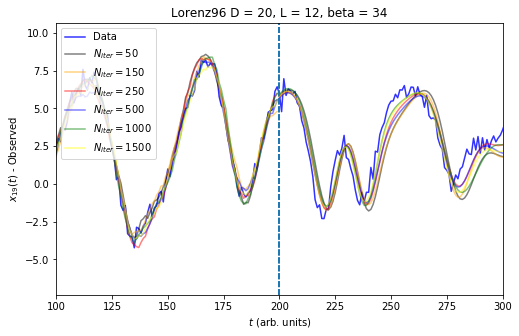

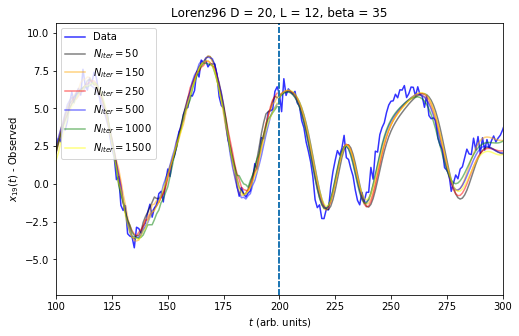

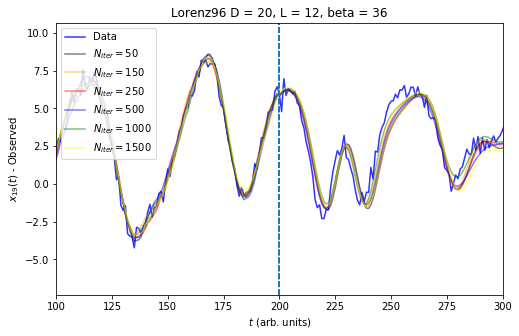

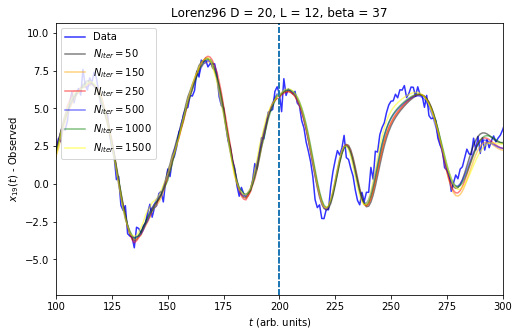

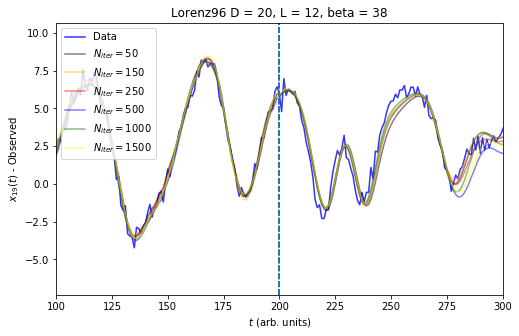

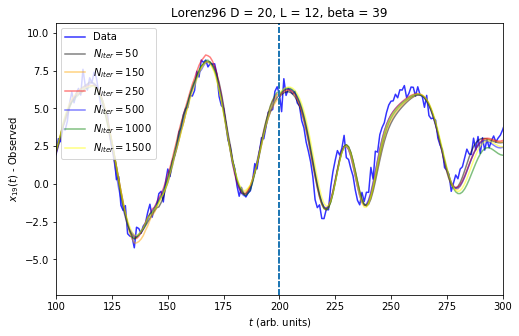

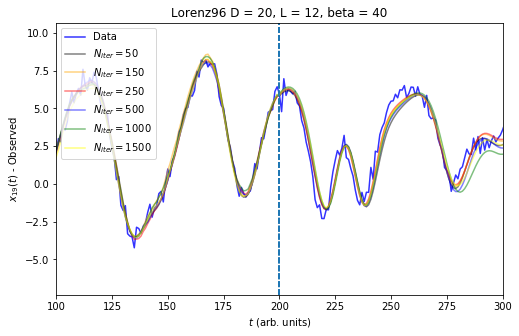

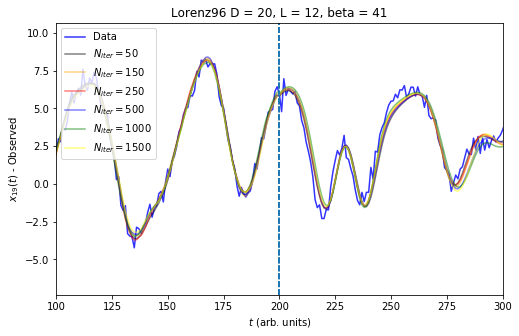

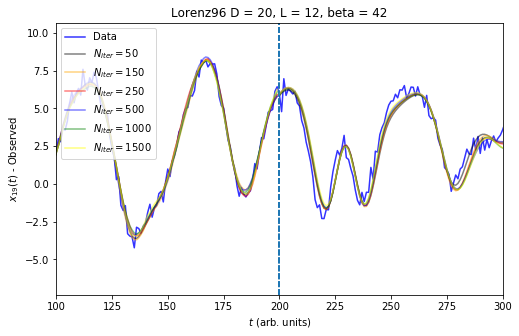

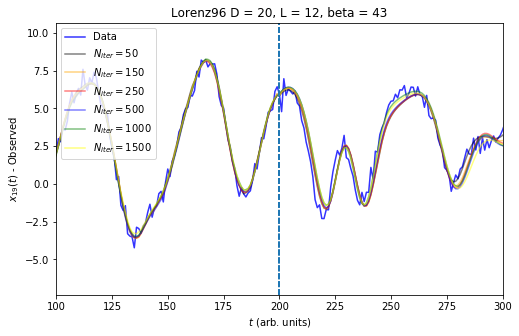

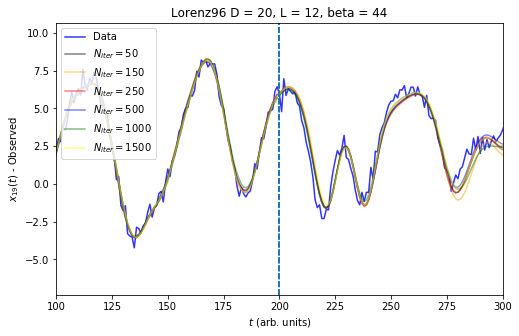

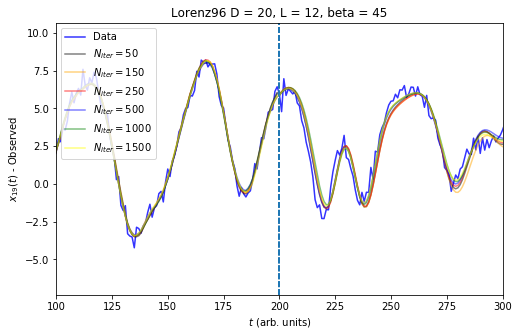

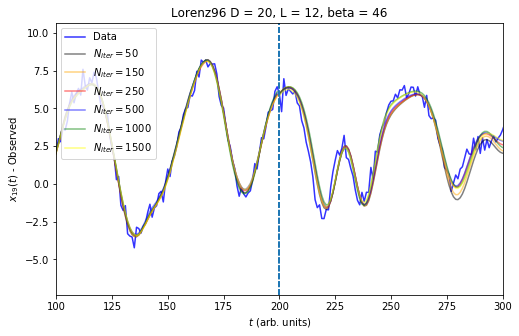

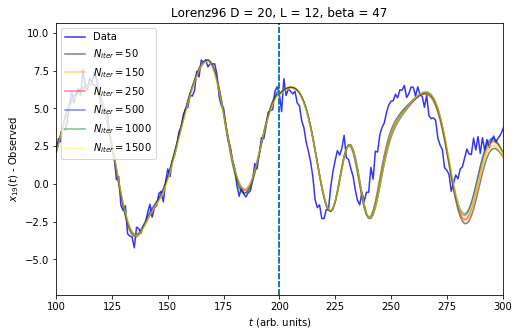

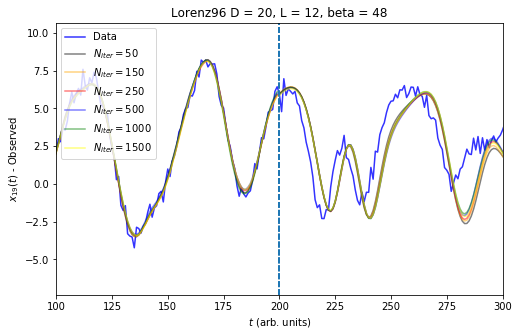

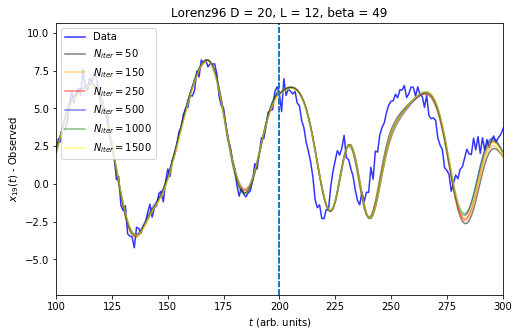

In [12]:
def plot_wrapping(var, beta):
    fig, ax = plt.subplots(figsize=(8,5))

    ax.plot(np.arange(1000), data[var,:1000], color='b', alpha=0.8, label='Data')
#     plot_mean_estimate(L25_q_min, color='black', label='$L^*=25$', ax, var, beta)
    
    q_min_list = [N50_q_min, N150_q_min, N250_q_min, N500_q_min, base_q_min, N1500_q_min]
    color_list = ['black', 'orange', 'red', 'blue', 'green', 'yellow']
    label_list = ['$N_{iter}=%s$'%num for num in ['50', '150', '250', '500', '1000', '1500']]
    
#     plot_mean_estimate(L25_q_min, color='black', label='$L^*=25$', ax, var, beta)
#     plot_mean_estimate(L50_q_min, color='orange', label='$L^*=50$', ax, var, beta)
#     plot_mean_estimate(L100_q_min, color='red', label='$L^*=100$', ax, var, beta)
#     plot_mean_estimate(base_q_min, color='blue', label='$L^*=150$', ax, var, beta)
#     plot_mean_estimate(L200_q_min, color='green', label='$L^*=200$', ax, var, beta)
    for q_min, color, label in zip(q_min_list, color_list, label_list):
        plot_mean_estimate(q_min, color, label, ax, var, beta)


    plt.title('Lorenz96 D = 20, L = 12, beta = %d' % beta)
    plt.xlabel(r'$t$ (arb. units)')
    plt.ylabel(r'$x_{%d}(t)$ - Observed'%var)
    plt.legend(loc=2)
#     plt.savefig("LstarEstimations-Obs.png")
    
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image

kwargs_write = {'fps':4.0, 'quantizer':'nq'}
imageio.mimsave('./Niterestimates-unobs-4fps.gif', [plot_wrapping(var=19, beta=i) for i in range(0,50)], fps=4)